<h1 style="text-align: center; vertical-align: middle;">Reinforcement learning for focusing and steering tasks</h1>
<h2 style="text-align: center; vertical-align: middle;">Use case: ARES linear accelerator at DESY</h2>

<h3 style="text-align: center; vertical-align: middle;">Implementation example for RL4AA'23 workshop</h3>

<p style="text-align: center; vertical-align: middle;">Jan Kaiser, Chenran Xu, Andrea Santamaria Garcia, Simon Hirländer</p>

<h2 style="color: #b51f2a">Introduction: ARES</h2>

<h2 style="color: #b51f2a">Refresher: the RL problem</h2>
<img src="img/rl_problem_1.png" width="70%"/>
<img src="img/rl_problem_2.png" width="70%"/>

<h2 style="color: #b51f2a">Goal</h2>

<h2 style="color: #b51f2a">Actions</h2>
<img src="img/ares_magnets.png" width="70%"/>
<h3>Dipole magnets</h3>
<h3>Quadrupole magnets</h3>

<h2 style="color: #b51f2a">Observation</h2>

<h2 style="color: #b51f2a">Reward</h2>

<h2 style="color: #b51f2a">Environment</h2>

<h2 style="color: #b51f2a">Agent</h2>

In [1]:
from time import sleep

import names
import numpy as np
from stable_baselines3 import PPO

from utils.rl.ea_train import train as train_ares_ea
from utils.rl.ea_train import make_env, read_from_yaml
from utils.rl.helpers import (
    evaluate_ares_ea_agent,
    make_ares_ea_training_videos,
    plot_ares_ea_training_history,
    show_video,
)
from utils.rl.utils import NotVecNormalize


Training a good agent revolves primarily around finding the right setup for the environment and the correct reward function. In order to iterate over and compare many different options, our training function takes a dictionary such as the one below.

Feel free to change things and see how they might affect the final agents.

**Note:** Traing can take a while. The actual function call is therefore commented out and we provide data from a training that we have prepared earlier.

In [2]:
config = {
    # If this property is set to True, episodes are aborted when the beam is no longer
    # on the screen.
    "abort_if_off_screen": True,
    # You may set this to "direct" or "delta". You should find that "delta" trains faster.
    # Setting "delta" is also crucial in running the agent on the real accelerator.
    "action_mode": "delta",
    # Batch size of the neural network training in the PPO algorithm
    "batch_size": 100,
    # Set lower to make rewards now more important than rewards later (usually above 0.9)
    "gamma": 0.99,
    # Set to [0,1,3] to only train focusing or to None to train positioning and focusing (hard)
    "filter_action": [0,1,3],
    # Setting this to None will include misalignments and incoming beam in the observation.
    # Change to ["beam","magnets"] for it to be like the real world.
    "filter_observation": ["beam", "magnets"],
    # Give multiple stacked (over time) observations to the agent. Can help overcome partial observability.
    "frame_stack": None,
    # You can have the magnets always start at the same constant settings during training. This can
    # be useful if you know the solution to be near some settings. To achieve this, set "magnet_init_mode"
    # to "constant" and "magnet_init_values" to a NumPy array of five values in the order that the magnets
    # are passed by the beam. Otherwise set "magnet_init_mode" to "random" and the magnets will always start
    # at different settings.
    "magnet_init_mode": "constant",
    "magnet_init_values": np.array([10, -10, 0, 10, 0]),
    # Set "misalignment_mode" to "constant" and "misalignment_values" to turn misalignments off. Otherwise set
    # "misalignment_mode" to "random".
    "misalignment_mode": "constant",
    "misalignment_values": np.zeros(8),
    # Changes the number of simulations that are trained on concurrently
    "n_envs": 40,
    # Changes the number of steps that data is gathered for from all simulations before training the policy
    # in each iteration of the PPO algorithm.
    "n_steps": 100,
    # Normalise observations throughout training by fitting a running mean and standard deviation of them.
    "normalize_observation": True,
    # Normalise rewards throughout training by fitting a running mean and standard deviation of them.
    "normalize_reward": True,
    # Take the limits of the magnet settings and scale them into the following range.
    "rescale_action": (-3, 3),
    # Can be set to "feedback" for punishment proportional to distance to target beam (r = negative objective),
    # or set to "delta" for reward based on improvement of the distance to the
    # target beam (r = previous objective - current objective).
    "reward_mode": "negative_objective",
    # Automatically assigns this agent a random name
    "run_name": names.get_full_name(),
    # The following two set the target beam during training to always the perfectly centered and focused as
    # small as possible. Set "target_beam_values" in order (x, width, y, height) to specialise on a different
    # target beam or set "target_beam_mode" to "random" to generalise over target beams.
    "target_beam_mode": "constant",
    "target_beam_values": np.zeros(4),
    # Threshols for beam parameters. If all beam parameters are within the thresholf from their target,
    # episodes end and the agent will stop optimising.
    "target_mu_x_threshold": np.inf,
    "target_mu_y_threshold": np.inf,
    "target_sigma_x_threshold": 4e-5,
    "target_sigma_y_threshold": 4e-5,
    # Number of interactions with the environment that the agent is allowed to traing for.
    "total_timesteps": 300_000,
    # Number of steps that beam parameters must be within threshold for the episode to end. Higher values make
    # agnets not just pass by the target, but actually stop.
    "threshold_hold": 5,
    # Number of interactions the agent gets to tune the magnets.
    "time_limit": 25,
    "vec_env": "dummy",
}

# Toggle comment to re-run the training (can take very long)
train_ares_ea(config)


==> Training agent "Ted Whitlatch"
Eval num_timesteps=20000, episode_reward=-0.01 +/- 0.00
Episode length: 25.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=-0.00 +/- 0.00
Episode length: 21.80 +/- 6.40
New best mean reward!
Eval num_timesteps=60000, episode_reward=-0.00 +/- 0.00
Episode length: 25.00 +/- 0.00
New best mean reward!
Eval num_timesteps=80000, episode_reward=-0.00 +/- 0.00
Episode length: 25.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=-0.00 +/- 0.00
Episode length: 25.00 +/- 0.00
Eval num_timesteps=120000, episode_reward=-0.00 +/- 0.00
Episode length: 25.00 +/- 0.00
Eval num_timesteps=140000, episode_reward=-0.00 +/- 0.00
Episode length: 21.20 +/- 7.60
New best mean reward!
Eval num_timesteps=160000, episode_reward=-0.00 +/- 0.00
Episode length: 21.20 +/- 7.60
Eval num_timesteps=180000, episode_reward=-0.00 +/- 0.00
Episode length: 21.60 +/- 6.80
Eval num_timesteps=200000, episode_reward=-0.00 +/- 0.00
Episode length: 21.40 +/- 7.20
E

As before we can look at the training metrics and check out videos taken at different stages of the training ...

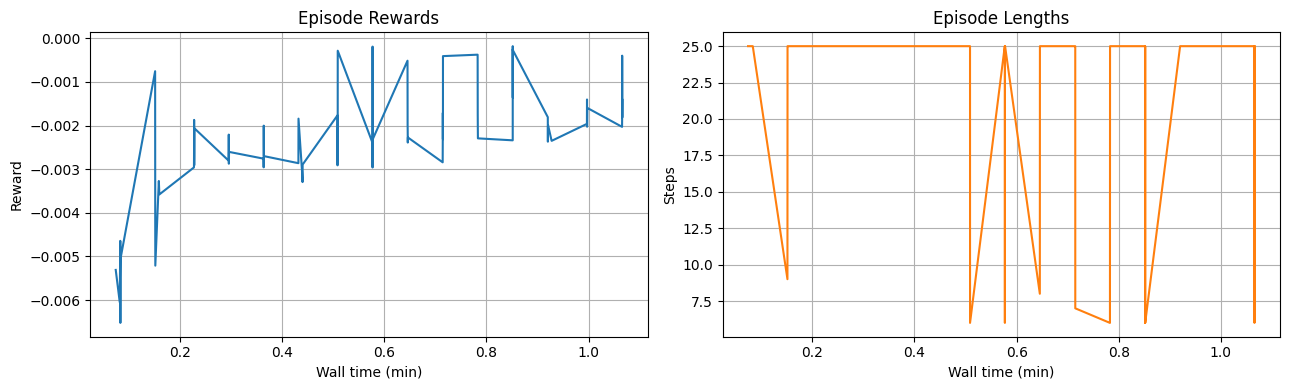

In [3]:
# Training curves from this training
# Change `config["run_name"` to `"ml_worksop` to see curves from example training.
plot_ares_ea_training_history(config["run_name"])


To look at videos of the agent during training, find the first output line of the training cell. Your agent should have a name (e.g. *Fred Rogers*). Find the subdirectory `utils/rl/ares_ea/recordings/`. There should be a directory for the name of your agent with video files in it. The `ml_workshop` directory contains videos from an example training.

Run the following cell to evaluate your agent. This is the mean deviation of the beam parameters from the target. Lower results are better.

If you are training agents that include the dipoles, set the functions argument `include_position=True`.

In [4]:
evaluate_ares_ea_agent(config["run_name"], include_position=False, n=2000)


==> Achieved a score of 4.237602404192842e-05 (2000 evaluations)


We can also test the trained agent on a simulation.

If you want to see an example agent instead of the one you just trained, set `agent_name="ml_workshop"`.

In [2]:
# Run final agent
agent_name = config["run_name"]

loaded_model = PPO.load(f"utils/rl/ares_ea/models/{agent_name}/model")
loaded_config = read_from_yaml(f"utils/rl/ares_ea/models/{agent_name}/config")

env = make_env(loaded_config, record_video=True)
env = NotVecNormalize(env, f"utils/rl/ares_ea/models/{agent_name}/normalizer")

done = False
observation = env.reset()
while not done:
    action, _ = loaded_model.predict(observation)
    observation, reward, done, info = env.step(action)
env.close()


### Running in the real world

Below you can see one of our final trained agents optimising position and focus of the beam on the real ARES accelerator.

Keep in mind that this agent has never seen the real accelerator before. All it has ever seen is a very simple linear beam dynamics simulation. Despite that it performs well on the real accelerator where all kinds of other effects come into the mix.

Note that this does not happen by itself and is the result of various careful decisions when designing the traiing setup.

Once trained, the agent is, however, trivial to use and requires no futher tuning or knowledge of RL.

In [6]:
# Show polished donkey running (on real accelerator)
show_video("utils/rl/rl-video-episode-1727.mp4")


## Further Resources

### Getting started in RL
 - [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/index.html) - Very understandable explainations on RL and the most popular algorithms acompanied by easy-to-read Python implementations.
 - [Reinforcement Learning with Stable Baselines 3](https://youtube.com/playlist?list=PLQVvvaa0QuDf0O2DWwLZBfJeYY-JOeZB1) - YouTube playlist giving a good introduction on RL using Stable Baselines3.
 - [Build a Doom AI Model with Python](https://youtu.be/eBCU-tqLGfQ) - Detailed 3h tutorial of applying RL using *DOOM* as an example.
 - [An introduction to Reinforcement Learning](https://youtu.be/JgvyzIkgxF0) - Brief introdution to RL.
 - [An introduction to Policy Gradient methods - Deep Reinforcement Learning](https://www.youtube.com/watch?v=5P7I-xPq8u8) - Brief introduction to PPO.

### Papers

 - [Learning-based optimisation of particle accelerators under partial observability without real-world training](https://proceedings.mlr.press/v162/kaiser22a.html) - Tuning of electron beam properties on a diagnostic screen using RL.
 - [Sample-efficient reinforcement learning for CERN accelerator control](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.23.124801) - Beam trajectory steering using RL with a focus on sample-efficient training.
 - [Autonomous control of a particle accelerator using deep reinforcement learning](https://arxiv.org/abs/2010.08141) - Beam transport through a drift tube linac using RL.
 - [Basic reinforcement learning techniques to control the intensity of a seeded free-electron laser](https://www.mdpi.com/2079-9292/9/5/781/htm) - RL-based laser alignment and drift recovery.
 - [Real-time artificial intelligence for accelerator control: A study at the Fermilab Booster](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.24.104601) - Regulation of a gradient magnet power supply using RL and real-time implementation of the trained agent using field-programmable gate arrays (FPGAs).
 - [Magnetic control of tokamak plasmas through deep reinforcement learning](https://www.nature.com/articles/s41586-021-04301-9) - Landmark paper on RL for controling a real-world physical system (plasma in a tokamak fusion reactor).

### Literature
 
 - [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) - Standard text book on RL.

### Packages
 - [Gym](https://www.gymlibrary.ml) - Defacto standard for implementing custom environments. Also provides a library of RL tasks widely used for benchmarking.
 - [Stable Baslines3](https://github.com/DLR-RM/stable-baselines3) - Provides reliable, benchmarked and easy-to-use implementations of the most important RL algorithms.
 - [Ray RLlib](https://docs.ray.io/en/latest/rllib/index.html) - Part of the *Ray* Python package providing implementations of various RL algorithms with a focus on distributed training.